In [25]:
import sys
sys.path.append('../../')

import torch as tc
import numpy as np

import matplotlib.pyplot as plt

import pandas as pd

from rcgp.rcgp import SpatioTemporalRCGP
from matplotlib.colors import LinearSegmentedColormap

from tqdm import tqdm

from data.simulations import spatio_temporal_half_contaminated

plt.rc('font', family='serif', size=12)

In [2]:
ts, grids, Ys, true_Ys, Ys_no_outliers, outliers_loc, n_lon, n_lat, lon_norm, lat_norm = spatio_temporal_half_contaminated()

In [3]:
def scoring_rule(Ys : tc.Tensor, preds : tc.Tensor, covs : tc.Tensor, R : tc.Tensor, Ws: tc.Tensor):

    S = covs + R
    eps = Ys - preds

    mahalanobis_dist = (eps.mT @ tc.linalg.inv(S) @ eps).squeeze()
    norm_const = tc.logdet(2 * tc.pi * S)

    energies = 0.5 * (norm_const + mahalanobis_dist)
    
    return energies.sum()

100%|██████████| 20/20 [00:22<00:00,  1.11s/it]


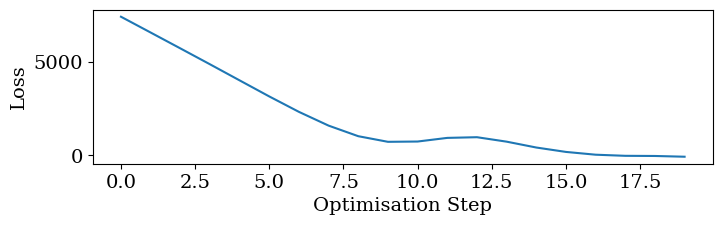

In [15]:
gp_std = SpatioTemporalRCGP(ts=ts, grid=grids[0], Ys=Ys, p=1)
gp_std.deactivate_robustness()

losses = []
n_steps = 20
lr = 0.4

optimizer = tc.optim.Adam(gp_std.parameters(), lr=lr)


for step in tqdm(range(n_steps)):
    _,(preds, covs, R, Ws), _ = gp_std.forward(smoothing=False)

    loss = scoring_rule(Ys=Ys_no_outliers, preds=preds, covs=covs, R=R, Ws=Ws)
    loss.backward()
    losses.append(loss.clone().detach())
    
    optimizer.step()  # Update parameters
    optimizer.zero_grad()  # Reset gradients

plt.figure(figsize=(8,2))
plt.plot(losses)
plt.ylabel("Loss")
plt.xlabel("Optimisation Step");

In [16]:
with tc.no_grad():
    (preds_std_smooth, stds_std_smooth, eff_std), _, _ = gp_std.forward()

100%|██████████| 20/20 [00:22<00:00,  1.12s/it]


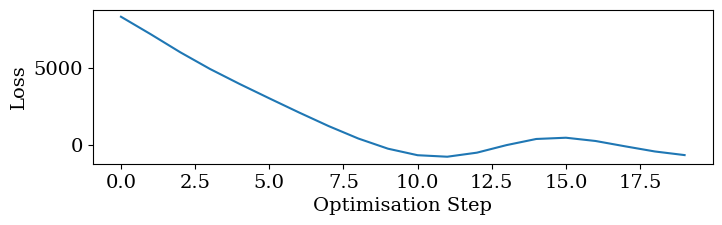

In [19]:
gp_IMQ = SpatioTemporalRCGP(ts=ts, grid=grids[0], Ys=Ys, p=1)

gp_IMQ.activate_robustness(func="local_constant") 
gp_IMQ._K_w_lengthscale = 1.

gp_IMQ.adaptive_c()

losses = []
n_steps = 20
lr = 0.4

optimizer = tc.optim.Adam(gp_IMQ.parameters(), lr=lr)


for step in tqdm(range(n_steps)):
    _,(preds, covs, R, Ws), _ = gp_IMQ.forward(smoothing=False)

    loss = scoring_rule(Ys=Ys_no_outliers, preds=preds, covs=covs, R=R, Ws=Ws)
    loss.backward()
    losses.append(loss.clone().detach())
    
    optimizer.step()  # Update parameters
    optimizer.zero_grad()  # Reset gradients

plt.figure(figsize=(8,2))
plt.plot(losses)
plt.ylabel("Loss")
plt.xlabel("Optimisation Step");

In [20]:
with tc.no_grad():
    (preds_IMQ_smooth, stds_IMQ_smooth, eff_IMQ), _, _ = gp_IMQ.forward()

In [29]:
def plot(t, R, Y, pred1, pred2, pred1_title, pred2_title, title="Spatio-Temporal GP"):

    time_idx_to_plot = [5, 7, 9]
    n_time_steps = len(time_idx_to_plot)

    fig, axs = plt.subplots(4, n_time_steps, figsize=(6,4), sharex=True, sharey=True)
    times = []
    left_noise_abs_diff = []
    left_pred1_abs_diff = []
    left_pred2_abs_diff = []

    right_noise_abs_diff = []
    right_pred1_abs_diff = []
    right_pred2_abs_diff = []

    colors = [
    (12/255, 44/255, 132/255),  # Deep Ocean Blue
    (30/255, 94/255, 172/255),  # Rich Blue
    (72/255, 150/255, 205/255),  # Sky Blue
    (144/255, 205/255, 220/255),  # Soft Cyan
    (234/255, 242/255, 227/255),  # Pale Mint
    (250/255, 210/255, 130/255),  # Light Gold
    (250/255, 190/255, 85/255),   # Soft Golden Orange
    ]

    cmap = LinearSegmentedColormap.from_list("MLPaperColormap", colors, N=1024)

    for idx, time_idx in enumerate(time_idx_to_plot):

        Y_arr = Y[time_idx].reshape(n_lon, n_lat).T
        Ys_no_outliers_arr = Ys_no_outliers[time_idx].reshape(n_lon, n_lat).T
        pred1_arr = pred1[time_idx].reshape(n_lon, n_lat).T
        pred2_arr = pred2[time_idx].reshape(n_lon, n_lat).T
        Ys_true = true_Ys[time_idx].reshape(n_lon, n_lat).T
        t_val = float(t[time_idx][0])

        vmin = Ys_no_outliers_arr.min()
        vmax = Ys_no_outliers_arr.max()

        times.append(t_val)

        x_split_idx = np.argmin(lon_norm < 0)

        left_noise_abs_diff.append(np.sqrt(((Y_arr[:, :x_split_idx] - Ys_true[:, :x_split_idx])**2).sum()))
        left_pred1_abs_diff.append(np.sqrt(((pred1_arr[:, :x_split_idx] - Ys_true[:, :x_split_idx])**2).sum()))
        left_pred2_abs_diff.append(np.sqrt(((pred2_arr[:, :x_split_idx] - Ys_true[:, :x_split_idx])**2).sum()))


        right_noise_abs_diff.append(np.sqrt(((Y_arr[:, x_split_idx:] - Ys_true[:, x_split_idx:])**2).sum()))
        right_pred1_abs_diff.append(np.sqrt(((pred1_arr [:, x_split_idx:] - Ys_true[:, x_split_idx:])**2).sum()))
        right_pred2_abs_diff.append(np.sqrt(((pred2_arr[:, x_split_idx:] - Ys_true[:, x_split_idx:])**2).sum()))
  

        R_arr = R[time_idx]
        X_lon = R_arr[:, 0].reshape(n_lon, n_lat).T
        X_lat = R_arr[:, 1].reshape(n_lon, n_lat).T
    
        im = axs[0, idx].contourf(X_lon, X_lat, Ys_no_outliers_arr, cmap=cmap)
        outliers_loc_t = outliers_loc[np.where(np.isclose(outliers_loc[:, 0], t_val))]
        axs[0, idx].scatter(outliers_loc_t[:, 1], outliers_loc_t[:, 2], marker='.', s=5., color='red')

        axs[1, idx].contourf(X_lon, X_lat, pred1_arr, vmin=vmin, vmax=vmax, cmap=cmap)

        axs[2, idx].contourf(X_lon, X_lat, pred2_arr, vmin=vmin, vmax=vmax, cmap=cmap)

        axs[3, idx].contourf(X_lon, X_lat, Ys_true, vmin=vmin, vmax=vmax, cmap=cmap)


        axs[0, idx].set_title("t={:.2f}".format(float(t[time_idx][0])))

        axs[0,0].set_ylabel("Data")
        axs[1,0].set_ylabel(pred1_title)
        axs[2,0].set_ylabel(pred2_title)
        axs[3,0].set_ylabel("Truth")
    
    #fig.colorbar(im, ax=axs)
    cbar = fig.colorbar(im, ax=axs, orientation="vertical", fraction=0.046, pad=0.04)

    #cax, kw = mpl.colorbar.make_axes([ax for ax in axs.flat])
    #plt.colorbar(im, cax=cax, **kw)
    
    #fig.suptitle(title)

    df = pd.DataFrame(np.vstack([times, left_noise_abs_diff, left_pred1_abs_diff, left_pred2_abs_diff, right_noise_abs_diff, right_pred1_abs_diff, right_pred2_abs_diff]))
    df.index = ["times", "RMSE (Data, left)", pred1_title + " RMSE (left)", pred2_title + " RMSE (left)", "RMSE (Data, right)", pred1_title + " RMSE (right)", pred2_title + " RMSE (right)"]
    return df

,times,"RMSE (Data, left)",STGP RMSE (left),ST-RCGP RMSE (left),"RMSE (Data, right)",STGP RMSE (right),ST-RCGP RMSE (right)
0,0.533333,35.671524,5.688744,0.556591,13.414822,2.374806,0.732061
1,0.666667,39.513908,6.574383,0.571981,9.135121,2.098155,0.662753
2,0.800000,31.249495,4.243922,0.902034,7.066812,1.657238,0.821999


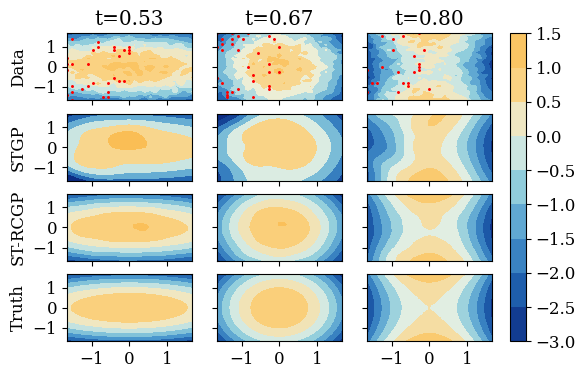

In [31]:
df = plot(ts, grids, Ys, pred1=preds_std_smooth, pred2=preds_IMQ_smooth, pred1_title="STGP", pred2_title="ST-RCGP", title="Spatio-Temporal GP - Simulation")
df.T
#plt.savefig("./simulated-spatio-temporal-optim.pdf", format='pdf', bbox_inches='tight')